Experiment description
 - Continual Learning using MLP model
 - CL strategy: Off-line learning
 - Dataset: 50% of IDS 2018 (5 out of 10 csv files)
 - Task organization: each csv file is assigned to a task. totally 5 tasks 
 - Data preprocessing: .h5 file -> pandas DataFrame -> Encode labels -> pytorch Dataset, DataLoader
 
Experiment Result: 
 - reasoning for the result: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torch.utils.data.dataloader import default_collate
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

import os
import sys
dest_path = '/content/drive/MyDrive/Colab Notebooks/CL_experiments_CICFlowdata/'
sys.path.append(dest_path)
import utils


In [ ]:
# Define relevant variables for the ML task
num_batch = 32
num_class = 10
num_epoch = 20

encoder = LabelEncoder()

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load full y data to encode label
y_all = pd.HDFStore(dest_path + 'ids2018_all_y.h5','r')
num_task = len(y_all.keys())

### Preprocessing

In [ ]:
# Load full y data to encode label
y_all = pd.HDFStore(dest_path + 'ids2018_all_y.h5','r')

df_y_all0302 = y_all.get('/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv')
df_y_all0216 = y_all.get('/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv')
df_y_all0214 = y_all.get('/Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv')
df_y_all0221 = y_all.get('/Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv')
df_y_all0228 = y_all.get('/Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv')
df_y_all = pd.concat([df_y_all0302, df_y_all0216, df_y_all0214, df_y_all0221, df_y_all0228], ignore_index=True)

In [ ]:
encoder.fit(df_y_all)
encoder.classes_

array(['Benign', 'Bot', 'DDOS attack-HOIC', 'DDOS attack-LOIC-UDP',
       'DoS attacks-Hulk', 'DoS attacks-SlowHTTPTest', 'FTP-BruteForce',
       'Infilteration', 'SSH-Bruteforce'], dtype=object)

In [ ]:
# Prepare datasets
# t#: task number, trds: training dataset, vds: validation dataset, teds: test dataset
tk_trdses = utils.buildDataset('train', dest_path, num_task, encoder)
tk_vdses = utils.buildDataset('val', dest_path, num_task, encoder)
sm_vds =  utils.buildDataset('val', dest_path, 1, encoder)

# Prepare cumulative training datasets
cu_trdses = []
cu_trdses.append(tk_trdses[0])
for i in range(0, num_task-1):
  cu_trdses.append(ConcatDataset([cu_trdses[i], tk_trdses[i+1]]))

In [ ]:
# Prepare DataLoaders
# t#: task number, trdl: training dataloader, vdl: validation dataloader, tedl: test dataloader

# load task-specific training & test dataset - from training_datasets
cu_tk_trdls = []
for i in range(0, num_task):
  cu_tk_trdls.append(DataLoader(cu_trdses[i], batch_size=num_batch, shuffle=True))

tk_vdls = []
for i in range(0, num_task):
  tk_vdls.append(DataLoader(tk_vdses[i], batch_size=num_batch, shuffle=True))
# load general test dataset - from test_datasets
sm_vdl = DataLoader(sm_vds, batch_size=num_batch, shuffle=True)

In [ ]:
# Check Data Shape
# Check # of samples in each set

utils.data_size_check(cu_tk_trdls, "task-specific train")
utils.data_size_check(tk_vdls, "task-specific validation")
utils.data_size_check([sm_vdl], "Overall test")

Data size check of task-specific train DataLoaders
Task_1:
t1_task-specific train:
# of samples: 62874
data size: torch.Size([32, 77])
data[0] size: torch.Size([77])
labels size: torch.Size([32])

Task_2:
t2_task-specific train:
# of samples: 125721
data size: torch.Size([32, 77])
data[0] size: torch.Size([77])
labels size: torch.Size([32])

Task_3:
t3_task-specific train:
# of samples: 188342
data size: torch.Size([32, 77])
data[0] size: torch.Size([77])
labels size: torch.Size([32])

Task_4:
t4_task-specific train:
# of samples: 251264
data size: torch.Size([32, 77])
data[0] size: torch.Size([77])
labels size: torch.Size([32])

Task_5:
t5_task-specific train:
# of samples: 287599
data size: torch.Size([32, 77])
data[0] size: torch.Size([77])
labels size: torch.Size([32])

------\--------
Data size check of task-specific validation DataLoaders
Task_1:
t1_task-specific validation:
# of samples: 20973
data size: torch.Size([32, 77])
data[0] size: torch.Size([77])
labels size: torch.Size

### Model

In [ ]:
# model = utils.CNN(num_class).to(device)
model = utils.MLP(input_size=77, output_size=len(encoder.classes_), hidden_dropout=True, input_dropout=True).to(device)
model.double()
#Use CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
#Use SGD, learning rate=0.001
learning_rate = 0.001
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

### Training & Evaluation

In [ ]:
train_ac_list = []

t1_test_ac_list = []
t2_test_ac_list = []
t3_test_ac_list = []
t4_test_ac_list = []
t5_test_ac_list = []
task_ac_list = np.zeros((5,6)).tolist()

test_ac_list = []

Period 1 - pretrained: [None] training [t1_train], testing [t1_test]

In [ ]:
print("Period 1 training")
for epoch in tqdm(range(num_epoch)):
    train_ac_list = utils.training(model, optimizer, cu_tk_trdls[0], train_ac_list, epoch, task_idx=1)

    t1_test_ac_list = utils.testing(model, tk_vdls[0], t1_test_ac_list, epoch, task_idx=1)
    
    if (epoch+1)%5 == 0:
        print('-------------------------------------------------------------------')

print()
test_ac_list = utils.testing(model, sm_vdl, test_ac_list, epoch=0, task_idx=0)

task_ac_list[0][0] = t1_test_ac_list[-1]  # task-specific test accuracy

Period 1 training


 20%|██        | 4/20 [00:21<01:22,  5.13s/it]

Epoch_5: task_1 Train_Acc: 0.9973


 25%|██▌       | 5/20 [00:26<01:14,  4.98s/it]

Epoch_5: task_1 Test_Acc: 0.9984
-------------------------------------------------------------------


 45%|████▌     | 9/20 [00:45<00:52,  4.77s/it]

Epoch_10: task_1 Train_Acc: 0.9977


 50%|█████     | 10/20 [00:50<00:47,  4.78s/it]

Epoch_10: task_1 Test_Acc: 0.9986
-------------------------------------------------------------------


 70%|███████   | 14/20 [01:09<00:28,  4.76s/it]

Epoch_15: task_1 Train_Acc: 0.9978


 75%|███████▌  | 15/20 [01:14<00:23,  4.74s/it]

Epoch_15: task_1 Test_Acc: 0.9985
-------------------------------------------------------------------


 95%|█████████▌| 19/20 [01:32<00:04,  4.75s/it]

Epoch_20: task_1 Train_Acc: 0.9976


100%|██████████| 20/20 [01:37<00:00,  4.89s/it]

Epoch_20: task_1 Test_Acc: 0.9985
-------------------------------------------------------------------



Epoch_1: Overall Test_Acc: 0.6357


Period 2 - pretrained: [t1_train] training [t2_train], testing [t1_test, t2_test]

In [ ]:
print("Period 2 training")
for epoch in tqdm(range(num_epoch)):
    train_ac_list = utils.training(model, optimizer, cu_tk_trdls[1], train_ac_list, epoch, task_idx=2)

    t1_test_ac_list = utils.testing(model, tk_vdls[0], t1_test_ac_list, epoch, task_idx=1)
    t2_test_ac_list = utils.testing(model, tk_vdls[1], t2_test_ac_list, epoch, task_idx=2)
    
    if (epoch+1)%5 == 0:
        print('-------------------------------------------------------------------')

print()
test_ac_list = utils.testing(model, sm_vdl, test_ac_list, epoch=0, task_idx=0)

task_ac_list[0][1] = t1_test_ac_list[-1]  # task-specific test accuracy
task_ac_list[1][1] = t2_test_ac_list[-1]

Period 2 training


 20%|██        | 4/20 [00:38<02:32,  9.54s/it]

Epoch_5: task_2 Train_Acc: 0.9976
Epoch_5: task_1 Test_Acc: 0.9971


 25%|██▌       | 5/20 [00:47<02:22,  9.53s/it]

Epoch_5: task_2 Test_Acc: 0.9997
-------------------------------------------------------------------


 45%|████▌     | 9/20 [01:26<01:45,  9.57s/it]

Epoch_10: task_2 Train_Acc: 0.9983
Epoch_10: task_1 Test_Acc: 0.9984


 50%|█████     | 10/20 [01:35<01:35,  9.54s/it]

Epoch_10: task_2 Test_Acc: 0.9998
-------------------------------------------------------------------


 70%|███████   | 14/20 [02:13<00:57,  9.52s/it]

Epoch_15: task_2 Train_Acc: 0.9985
Epoch_15: task_1 Test_Acc: 0.9984


 75%|███████▌  | 15/20 [02:23<00:47,  9.53s/it]

Epoch_15: task_2 Test_Acc: 1.0000
-------------------------------------------------------------------


 95%|█████████▌| 19/20 [03:01<00:09,  9.58s/it]

Epoch_20: task_2 Train_Acc: 0.9984
Epoch_20: task_1 Test_Acc: 0.9984


100%|██████████| 20/20 [03:11<00:00,  9.56s/it]

Epoch_20: task_2 Test_Acc: 1.0000
-------------------------------------------------------------------



Epoch_1: Overall Test_Acc: 0.7559


Period 3 - pretrained: [t1_train, t2_train] training [t3_train], testing [t1_test, t2_test, t3_test]

In [ ]:
print("Period 3 training")
for epoch in tqdm(range(num_epoch)):
    train_ac_list = utils.training(model, optimizer, cu_tk_trdls[2], train_ac_list, epoch, task_idx=3)

    t1_test_ac_list = utils.testing(model, tk_vdls[0], t1_test_ac_list, epoch, task_idx=1)
    t2_test_ac_list = utils.testing(model, tk_vdls[1], t2_test_ac_list, epoch, task_idx=2)
    t3_test_ac_list = utils.testing(model, tk_vdls[2], t3_test_ac_list, epoch, task_idx=3)
    
    if (epoch+1)%5 == 0:
        print('-------------------------------------------------------------------')

print()
test_ac_list = utils.testing(model, sm_vdl, test_ac_list, epoch=0, task_idx=0)

task_ac_list[0][2] = t1_test_ac_list[-1]  # task-specific test accuracy
task_ac_list[1][2] = t2_test_ac_list[-1]
task_ac_list[2][2] = t3_test_ac_list[-1]

Period 3 training


 20%|██        | 4/20 [00:57<03:49, 14.35s/it]

Epoch_5: task_3 Train_Acc: 0.9630
Epoch_5: task_1 Test_Acc: 0.9976
Epoch_5: task_2 Test_Acc: 0.9267


 25%|██▌       | 5/20 [01:11<03:35, 14.37s/it]

Epoch_5: task_3 Test_Acc: 0.9634
-------------------------------------------------------------------


 45%|████▌     | 9/20 [02:09<02:37, 14.36s/it]

Epoch_10: task_3 Train_Acc: 0.9640
Epoch_10: task_1 Test_Acc: 0.9982
Epoch_10: task_2 Test_Acc: 0.9238


 50%|█████     | 10/20 [02:23<02:23, 14.36s/it]

Epoch_10: task_3 Test_Acc: 0.9793
-------------------------------------------------------------------


 70%|███████   | 14/20 [03:20<01:25, 14.31s/it]

Epoch_15: task_3 Train_Acc: 0.9641
Epoch_15: task_1 Test_Acc: 0.9979
Epoch_15: task_2 Test_Acc: 0.9239


 75%|███████▌  | 15/20 [03:35<01:11, 14.30s/it]

Epoch_15: task_3 Test_Acc: 0.9790
-------------------------------------------------------------------


 95%|█████████▌| 19/20 [04:32<00:14, 14.38s/it]

Epoch_20: task_3 Train_Acc: 0.9638
Epoch_20: task_1 Test_Acc: 0.9980
Epoch_20: task_2 Test_Acc: 0.9241


100%|██████████| 20/20 [04:47<00:00, 14.36s/it]

Epoch_20: task_3 Test_Acc: 0.9781
-------------------------------------------------------------------



Epoch_1: Overall Test_Acc: 0.8142


Period 4 - pretrained: [t1_train, t2_train, t3_train] training [t4_train], testing [t1_test, t2_test, t3_train, t4_train]

In [ ]:
print("Period 4 training")
for epoch in tqdm(range(num_epoch)):
    train_ac_list = utils.training(model, optimizer, cu_tk_trdls[3], train_ac_list, epoch, task_idx=4)

    t1_test_ac_list = utils.testing(model, tk_vdls[0], t1_test_ac_list, epoch, task_idx=1)
    t2_test_ac_list = utils.testing(model, tk_vdls[1], t2_test_ac_list, epoch, task_idx=2)
    t3_test_ac_list = utils.testing(model, tk_vdls[2], t3_test_ac_list, epoch, task_idx=3)
    t4_test_ac_list = utils.testing(model, tk_vdls[3], t4_test_ac_list, epoch, task_idx=4)
    
    if (epoch+1)%5 == 0:
        print('-------------------------------------------------------------------')

print()
test_ac_list = utils.testing(model, sm_vdl, test_ac_list, epoch=0, task_idx=0)

task_ac_list[0][3] = t1_test_ac_list[-1]  # task-specific test accuracy
task_ac_list[1][3] = t2_test_ac_list[-1]
task_ac_list[2][3] = t3_test_ac_list[-1]
task_ac_list[3][3] = t4_test_ac_list[-1]

Period 4 training


 20%|██        | 4/20 [01:17<05:09, 19.32s/it]

Epoch_5: task_4 Train_Acc: 0.9705
Epoch_5: task_1 Test_Acc: 0.9942
Epoch_5: task_2 Test_Acc: 0.9261
Epoch_5: task_3 Test_Acc: 0.9730


 25%|██▌       | 5/20 [01:36<04:50, 19.35s/it]

Epoch_5: task_4 Test_Acc: 0.9983
-------------------------------------------------------------------


 45%|████▌     | 9/20 [02:53<03:31, 19.26s/it]

Epoch_10: task_4 Train_Acc: 0.9712
Epoch_10: task_1 Test_Acc: 0.9952
Epoch_10: task_2 Test_Acc: 0.9988
Epoch_10: task_3 Test_Acc: 0.8671


 50%|█████     | 10/20 [03:12<03:12, 19.24s/it]

Epoch_10: task_4 Test_Acc: 0.9983
-------------------------------------------------------------------


 70%|███████   | 14/20 [04:29<01:55, 19.24s/it]

Epoch_15: task_4 Train_Acc: 0.9709
Epoch_15: task_1 Test_Acc: 0.9954
Epoch_15: task_2 Test_Acc: 0.9264
Epoch_15: task_3 Test_Acc: 0.9723


 75%|███████▌  | 15/20 [04:49<01:36, 19.28s/it]

Epoch_15: task_4 Test_Acc: 0.9983
-------------------------------------------------------------------


 95%|█████████▌| 19/20 [06:06<00:19, 19.23s/it]

Epoch_20: task_4 Train_Acc: 0.9709
Epoch_20: task_1 Test_Acc: 0.9948
Epoch_20: task_2 Test_Acc: 0.9248
Epoch_20: task_3 Test_Acc: 0.9749


100%|██████████| 20/20 [06:25<00:00, 19.27s/it]

Epoch_20: task_4 Test_Acc: 0.9983
-------------------------------------------------------------------



Epoch_1: Overall Test_Acc: 0.9563


Period 5 - pretrained: [t1_train, t2_train, t3_train, t4_train] training [t5_train], testing [t1_test, t2_test, t3_train, t4_train, t5_train]

In [ ]:
print("Period 5 training")
for epoch in tqdm(range(num_epoch)):
    train_ac_list = utils.training(model, optimizer, cu_tk_trdls[4], train_ac_list, epoch, task_idx=5)

    t1_test_ac_list = utils.testing(model, tk_vdls[0], t1_test_ac_list, epoch, task_idx=1)
    t2_test_ac_list = utils.testing(model, tk_vdls[1], t2_test_ac_list, epoch, task_idx=2)
    t3_test_ac_list = utils.testing(model, tk_vdls[2], t3_test_ac_list, epoch, task_idx=3)
    t4_test_ac_list = utils.testing(model, tk_vdls[3], t4_test_ac_list, epoch, task_idx=4)
    t5_test_ac_list = utils.testing(model, tk_vdls[4], t5_test_ac_list, epoch, task_idx=5)

    
    if (epoch+1)%5 == 0:
        print('-------------------------------------------------------------------')

print()
test_ac_list = utils.testing(model, sm_vdl, test_ac_list, epoch=0, task_idx=0)

task_ac_list[0][4] = t1_test_ac_list[-1]  # task-specific test accuracy
task_ac_list[1][4] = t2_test_ac_list[-1]
task_ac_list[2][4] = t3_test_ac_list[-1]
task_ac_list[3][4] = t4_test_ac_list[-1]
task_ac_list[4][4] = t5_test_ac_list[-1]

Period 5 training


 20%|██        | 4/20 [01:28<05:52, 22.06s/it]

Epoch_5: task_5 Train_Acc: 0.9597
Epoch_5: task_1 Test_Acc: 0.9971
Epoch_5: task_2 Test_Acc: 0.9988
Epoch_5: task_3 Test_Acc: 0.8694
Epoch_5: task_4 Test_Acc: 0.9983


 25%|██▌       | 5/20 [01:50<05:31, 22.08s/it]

Epoch_5: task_5 Test_Acc: 0.8852
-------------------------------------------------------------------


 45%|████▌     | 9/20 [03:19<04:04, 22.22s/it]

Epoch_10: task_5 Train_Acc: 0.9599
Epoch_10: task_1 Test_Acc: 0.9976
Epoch_10: task_2 Test_Acc: 0.9265
Epoch_10: task_3 Test_Acc: 0.9700
Epoch_10: task_4 Test_Acc: 0.9983


 50%|█████     | 10/20 [03:41<03:42, 22.25s/it]

Epoch_10: task_5 Test_Acc: 0.8864
-------------------------------------------------------------------


 70%|███████   | 14/20 [05:10<02:13, 22.19s/it]

Epoch_15: task_5 Train_Acc: 0.9593
Epoch_15: task_1 Test_Acc: 0.9979
Epoch_15: task_2 Test_Acc: 0.9239
Epoch_15: task_3 Test_Acc: 0.9790
Epoch_15: task_4 Test_Acc: 0.9983


 75%|███████▌  | 15/20 [05:32<01:50, 22.16s/it]

Epoch_15: task_5 Test_Acc: 0.8865
-------------------------------------------------------------------


 95%|█████████▌| 19/20 [07:01<00:22, 22.30s/it]

Epoch_20: task_5 Train_Acc: 0.9599
Epoch_20: task_1 Test_Acc: 0.9978
Epoch_20: task_2 Test_Acc: 0.9168
Epoch_20: task_3 Test_Acc: 0.9815
Epoch_20: task_4 Test_Acc: 0.9983


100%|██████████| 20/20 [07:23<00:00, 22.19s/it]

Epoch_20: task_5 Test_Acc: 0.8862
-------------------------------------------------------------------



Epoch_1: Overall Test_Acc: 0.9624


### Visualize results

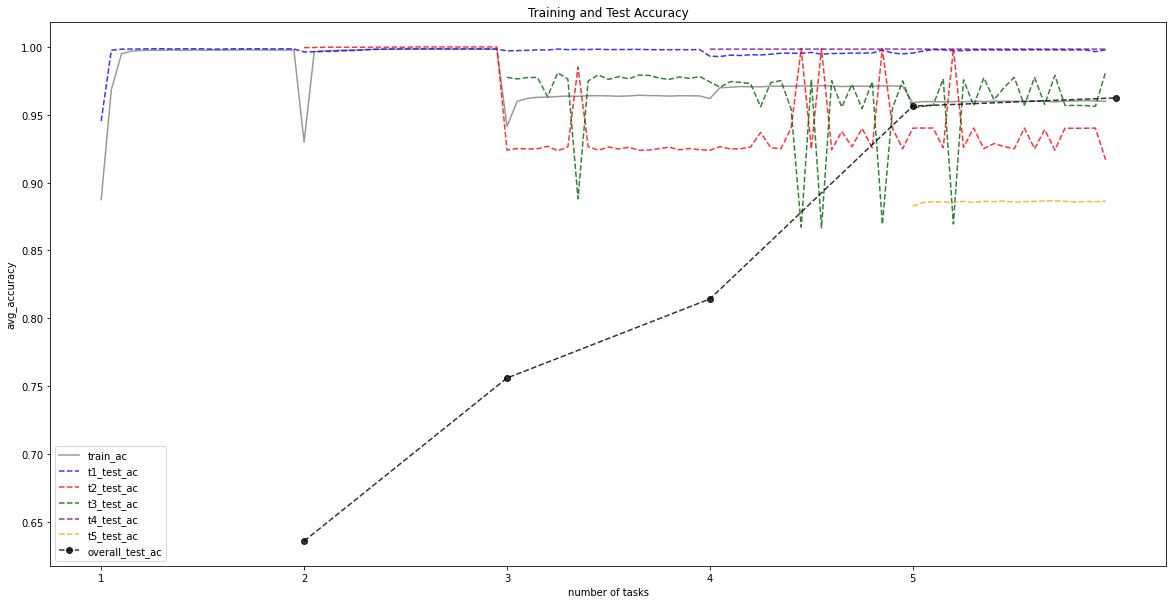

In [ ]:
#Plot - use all data in test accuracy of each task
plt.figure(figsize=[20,10])
plt.plot(np.arange(0, int(5*num_epoch)), train_ac_list, color='grey', linestyle='-', label='train_ac', alpha=0.8)
plt.plot(np.arange(0, int(5*num_epoch)), t1_test_ac_list, color='blue', linestyle='--', label='t1_test_ac', alpha=0.8)
plt.plot(np.arange(int(1*num_epoch), int(5*num_epoch)), t2_test_ac_list, color='red', linestyle='--', label='t2_test_ac', alpha=0.8)
plt.plot(np.arange(int(2*num_epoch), int(5*num_epoch)), t3_test_ac_list, color='darkgreen', linestyle='--', label='t3_test_ac', alpha=0.8)
plt.plot(np.arange(int(3*num_epoch), int(5*num_epoch)), t4_test_ac_list, color='purple', linestyle='--', label='t4_test_ac', alpha=0.8)
plt.plot(np.arange(int(4*num_epoch), int(5*num_epoch)), t5_test_ac_list, color='orange', linestyle='--', label='t5_test_ac', alpha=0.8)
plt.plot([20, 40, 60, 80, 100], test_ac_list, color='black', marker='o', linestyle='--', label='overall_test_ac', alpha=0.8)
plt.legend()
plt.title("Training and Test Accuracy")
plt.xlabel("number of tasks")
plt.ylabel("avg_accuracy")
plt.xticks([0, 20, 40, 60, 80],[1, 2, 3, 4, 5])
plt.show()

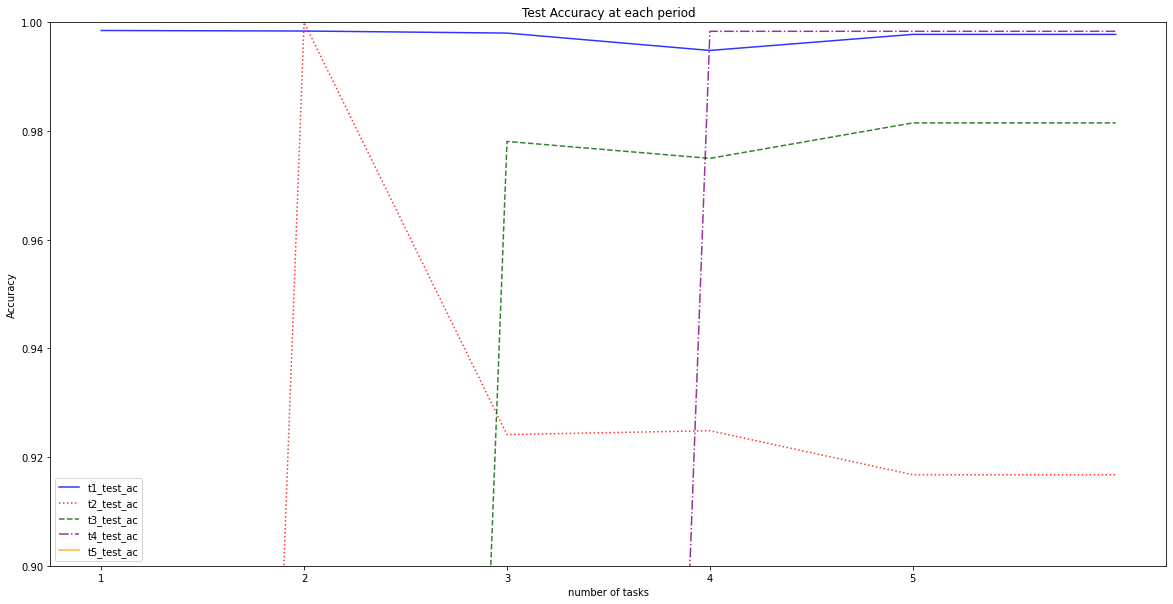

In [ ]:
#Plot - average accuracy of each task
for i in range(5):
  task_ac_list[i][5] = task_ac_list[i][4]

plt.figure(figsize=[20,10])
plt.plot(np.arange(1, 7), task_ac_list[0], color='blue', linestyle='solid', label='t1_test_ac', alpha=0.8)
plt.plot(np.arange(1, 7), task_ac_list[1], color='red', linestyle='dotted', label='t2_test_ac', alpha=0.8)
plt.plot(np.arange(1, 7), task_ac_list[2], color='darkgreen', linestyle='dashed', label='t3_test_ac', alpha=0.8)
plt.plot(np.arange(1, 7), task_ac_list[3], color='purple', linestyle='dashdot', label='t4_test_ac', alpha=0.8)
plt.plot(np.arange(1, 7), task_ac_list[4], color='orange', linestyle='solid', label='t5_test_ac', alpha=0.8)
plt.legend()
plt.title("Test Accuracy at each period")
plt.xlabel("number of tasks")
plt.ylabel("Accuracy")
plt.xticks([1, 2, 3, 4, 5])
plt.ylim([0.9, 1])
plt.show()


In [ ]:
"""
#Predict Sample 10 examples from MNIST
print("\nPredict \n")
idx = np.random.choice(10000, 10, True)

for i in idx:
    image = test_loader.dataset[i][0].reshape(1, 1, 28*28).float()
    output = model(image.to(device))
    y_pred = torch.argmax(output, dim=1)
    
    plt.figure(figsize=(1, 1))
    plt.imshow(test_loader.dataset[i][0].reshape(28,28), cmap=plt.cm.gray_r)
    plt.show()
    print("true_label: {}, y_pred: {}\n".format(test_loader.dataset[i][1], y_pred[0]))
"""

'\n#Predict Sample 10 examples from MNIST\nprint("\nPredict \n")\nidx = np.random.choice(10000, 10, True)\n\nfor i in idx:\n    image = test_loader.dataset[i][0].reshape(1, 1, 28*28).float()\n    output = model(image.to(device))\n    y_pred = torch.argmax(output, dim=1)\n    \n    plt.figure(figsize=(1, 1))\n    plt.imshow(test_loader.dataset[i][0].reshape(28,28), cmap=plt.cm.gray_r)\n    plt.show()\n    print("true_label: {}, y_pred: {}\n".format(test_loader.dataset[i][1], y_pred[0]))\n'